In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time

## Data Pre-processing##

In [2]:
# Import Dataset and remove empty rows
df = pd.read_csv('happy_customers.csv')
# df = df.dropna(subset=['reviews.text'])
df

,Reviewer_Score,reviews
0,10.0,Apart from the price for the brekfast Everyth...
1,10.0,Nothing all great Rooms were stunningly deco...
2,10.0,This hotel is awesome I took it sincirely bec...
3,10.0,The quality of the hotel was brilliant and ev...
4,10.0,I loved everything The location in a quiet p...
...,...,...
115848,10.0,Staff were very helpful Location was great fo...
115849,10.0,Good position close to the metro station in q...
115850,10.0,room was a bit small but it s OK Bed was goo...
115851,10.0,The breakfast was excelent lots of fress frui...


In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  115853
Columns  :  2

Features :  ['Reviewer_Score', 'reviews']

Missing values :   26

Unique values :  
 Reviewer_Score         1
reviews           110836
dtype: int64


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115853 entries, 0 to 115852
Data columns (total 2 columns):
Reviewer_Score    115853 non-null float64
reviews           115827 non-null object
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


Reviewer_Score     0
reviews           26
dtype: int64

In [5]:
df = df.sample(frac = 0.01, replace = False, random_state=42)

In [6]:
# Remove punctuation 
df['no_punctuation'] = df['reviews'].str.replace('[^\w\s]','')

# Change to lower case
df ['lower_case'] = df['no_punctuation'].astype(str).str.lower()

# Apply word tokenizer
df['tokenized_text'] = df['lower_case'].apply(word_tokenize)

# Remove stop words
df['key_words'] =df['tokenized_text'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])



df

,Reviewer_Score,reviews,no_punctuation,lower_case,tokenized_text,key_words
80338,10.0,Couldn t make tea or coffee as the uht milk t...,Couldn t make tea or coffee as the uht milk t...,couldn t make tea or coffee as the uht milk t...,"[couldn, t, make, tea, or, coffee, as, the, uh...","[make, tea, coffee, uht, milk, tasted, friendl..."
76731,10.0,Room service meal after 11pm not much to choo...,Room service meal after 11pm not much to choo...,room service meal after 11pm not much to choo...,"[room, service, meal, after, 11pm, not, much, ...","[room, service, meal, 11pm, much, choose, food..."
17339,10.0,staff were very helpful,staff were very helpful,staff were very helpful,"[staff, were, very, helpful]","[staff, helpful]"
81101,10.0,Loved the location the style of hotel and the...,Loved the location the style of hotel and the...,loved the location the style of hotel and the...,"[loved, the, location, the, style, of, hotel, ...","[loved, location, style, hotel, staff, brilliant]"
24629,10.0,No parking facilities but could have opted fo...,No parking facilities but could have opted fo...,no parking facilities but could have opted fo...,"[no, parking, facilities, but, could, have, op...","[parking, facilities, could, opted, valet, par..."
...,...,...,...,...,...,...
93902,10.0,Sadly the room had a smell and was equipped f...,Sadly the room had a smell and was equipped f...,sadly the room had a smell and was equipped f...,"[sadly, the, room, had, a, smell, and, was, eq...","[sadly, room, smell, equipped, handicapped, pe..."
84630,10.0,Breakfast to expensive Location confort,Breakfast to expensive Location confort,breakfast to expensive location confort,"[breakfast, to, expensive, location, confort]","[breakfast, expensive, location, confort]"
20962,10.0,Rooms could be bigger but that s being picky ...,Rooms could be bigger but that s being picky ...,rooms could be bigger but that s being picky ...,"[rooms, could, be, bigger, but, that, s, being...","[rooms, could, bigger, picky, hey, london, cle..."
13022,10.0,Bed is good but a little hard but thats usual...,Bed is good but a little hard but thats usual...,bed is good but a little hard but thats usual...,"[bed, is, good, but, a, little, hard, but, tha...","[bed, good, little, hard, thats, usually, difi..."


## Count Vectorizing ##

In [7]:
# Join the tokenized words for count vectorizing
df['joined_Sent'] = [' '.join(map(str, indStem)) for indStem in df['key_words']]
df

,Reviewer_Score,reviews,no_punctuation,lower_case,tokenized_text,key_words,joined_Sent
80338,10.0,Couldn t make tea or coffee as the uht milk t...,Couldn t make tea or coffee as the uht milk t...,couldn t make tea or coffee as the uht milk t...,"[couldn, t, make, tea, or, coffee, as, the, uh...","[make, tea, coffee, uht, milk, tasted, friendl...",make tea coffee uht milk tasted friendly helpf...
76731,10.0,Room service meal after 11pm not much to choo...,Room service meal after 11pm not much to choo...,room service meal after 11pm not much to choo...,"[room, service, meal, after, 11pm, not, much, ...","[room, service, meal, 11pm, much, choose, food...",room service meal 11pm much choose food servic...
17339,10.0,staff were very helpful,staff were very helpful,staff were very helpful,"[staff, were, very, helpful]","[staff, helpful]",staff helpful
81101,10.0,Loved the location the style of hotel and the...,Loved the location the style of hotel and the...,loved the location the style of hotel and the...,"[loved, the, location, the, style, of, hotel, ...","[loved, location, style, hotel, staff, brilliant]",loved location style hotel staff brilliant
24629,10.0,No parking facilities but could have opted fo...,No parking facilities but could have opted fo...,no parking facilities but could have opted fo...,"[no, parking, facilities, but, could, have, op...","[parking, facilities, could, opted, valet, par...",parking facilities could opted valet parking t...
...,...,...,...,...,...,...,...
93902,10.0,Sadly the room had a smell and was equipped f...,Sadly the room had a smell and was equipped f...,sadly the room had a smell and was equipped f...,"[sadly, the, room, had, a, smell, and, was, eq...","[sadly, room, smell, equipped, handicapped, pe...",sadly room smell equipped handicapped person r...
84630,10.0,Breakfast to expensive Location confort,Breakfast to expensive Location confort,breakfast to expensive location confort,"[breakfast, to, expensive, location, confort]","[breakfast, expensive, location, confort]",breakfast expensive location confort
20962,10.0,Rooms could be bigger but that s being picky ...,Rooms could be bigger but that s being picky ...,rooms could be bigger but that s being picky ...,"[rooms, could, be, bigger, but, that, s, being...","[rooms, could, bigger, picky, hey, london, cle...",rooms could bigger picky hey london cleanlines...
13022,10.0,Bed is good but a little hard but thats usual...,Bed is good but a little hard but thats usual...,bed is good but a little hard but thats usual...,"[bed, is, good, but, a, little, hard, but, tha...","[bed, good, little, hard, thats, usually, difi...",bed good little hard thats usually dificullity...


In [8]:
# Document-Term Matrix (Count Vectorizer)
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df["joined_Sent"])
df_doc_term = pd.DataFrame(sparse_matrix.toarray(), columns=word_vectorizer.get_feature_names())
df_doc_term.shape


(1159, 31383)

In [9]:
df_doc_term

,00,00 also,00 also advantage,00 despite,00 despite false,00 options,00 options really,10,10 10,10 10 room,...,yummy breakfasts roof,zap,zap expected,zap expected air,zarautz,zarautz well,zarautz well worth,zuid,zuid train,zuid train underground
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Topic Modelling - Count Vectorizer ##

### 1. Gensim###

In [10]:
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in word_vectorizer.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

35.60696601867676


In [11]:
lda.print_topics()

[(0,
  '0.016*"13 yr" + 0.015*"also enjoyed" + 0.013*"20 meters" + 0.011*"added bonus floor" + 0.010*"7th time" + 0.009*"air con broken" + 0.008*"25 degrees ipad" + 0.008*"almond milk forgot" + 0.008*"10 15 soho" + 0.007*"absolutly"'),
 (1,
  '0.013*"12 00 also" + 0.011*"aerobus terminal airport" + 0.010*"402" + 0.009*"absolutely dead" + 0.009*"also really" + 0.009*"activity great" + 0.009*"additional features expresso" + 0.008*"amazing huge" + 0.008*"10 stay" + 0.008*"also made feel"'),
 (2,
  '0.013*"actually work laptop" + 0.009*"activities" + 0.009*"add personal" + 0.008*"air conditioning seemed" + 0.008*"advantage gave" + 0.007*"amazing many" + 0.007*"amazing friends stayed" + 0.006*"accident getting bath" + 0.006*"9am ridiculous" + 0.006*"acknowledge partner birthday"')]

### 2.  LSA aka SVD###

In [12]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
hotel, room, staff, location, great, breakfast, friendly, helpful, good, excellent, stay, clean, comfortable, would, nice, nothing, rooms, really, lovely, bed

Topic  1
room, good, hotel, bed, would, shower, stay, also, minutes, coffee, really, bathroom, us, tea, first, view, floor, 10, station, nice

Topic  2
room, great, location, helpful, comfortable, staff, breakfast, great location, excellent, bed, friendly, coffee, shower, good, friendly staff, floor, helpful staff, service, free, large

Time Taken: 6.16 seconds


In [13]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 2 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
hotel, room, staff, location, great, breakfast, friendly, helpful, good, excellent, stay, clean, comfortable, would, nice, nothing, rooms, really, lovely, bed

Topic  1
room, good, hotel, bed, would, shower, stay, also, minutes, coffee, really, bathroom, us, tea, first, view, 10, floor, station, nice

Time Taken: 5.99 seconds


### 3. Non-Negative Matrix Factorization (NMF)### 

In [14]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names())
topic_word
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
staff, great, location, friendly, helpful, excellent, breakfast, great location, clean, nothing, comfortable, rooms, friendly helpful, friendly staff, food, helpful staff, staff friendly, lovely, everything, amazing

Topic  1
room, good, breakfast, bed, would, comfortable, really, shower, us, coffee, nice, stay, excellent, service, bathroom, view, floor, free, clean, also

Topic  2
hotel, stay, staff, would, location, london, perfect, rooms, breakfast, good, nice, nothing, definitely, clean, station, amazing, minutes, also, everything, really

Time Taken: 8.17 seconds


In [15]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names())
topic_word
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
staff, hotel, location, great, friendly, helpful, breakfast, excellent, nothing, clean, rooms, great location, stay, comfortable, amazing, friendly helpful, perfect, lovely, everything, staff friendly

Topic  1
room, hotel, good, breakfast, bed, would, stay, comfortable, really, nice, us, shower, coffee, excellent, also, service, clean, bathroom, view, minutes

Time Taken: 18.90 seconds


## Topic Modelling - TF-IDF Vectorizer##

In [16]:
# Document-Term Matrix - TF-IDF
cv_tfidf = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = cv_tfidf.fit_transform(df["joined_Sent"])
df_doc_term_TFIDF = pd.DataFrame(sparse_matrix.toarray(), columns=cv_tfidf.get_feature_names())
df_doc_term_TFIDF.shape
# df_doc_term_TFIDF.to_csv("df_doc_term_TFIDF.csv", index=True)

(1159, 31383)

In [17]:
df_doc_term_TFIDF

,00,00 also,00 also advantage,00 despite,00 despite false,00 options,00 options really,10,10 10,10 10 room,...,yummy breakfasts roof,zap,zap expected,zap expected air,zarautz,zarautz well,zarautz well worth,zuid,zuid train,zuid train underground
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Gensim###

In [18]:
lda.print_topics()
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

32.40643048286438


In [19]:
lda.print_topics()

[(0,
  '0.002*"13 yr" + 0.002*"actually work laptop" + 0.001*"added bonus floor" + 0.001*"amazing friends stayed" + 0.001*"although everything required" + 0.001*"air con broken" + 0.001*"also really" + 0.001*"amazing many" + 0.001*"almond milk forgot" + 0.001*"9pm understandable"'),
 (1,
  '0.001*"12 00 also" + 0.001*"402" + 0.001*"activities" + 0.001*"amazing huge" + 0.001*"additional features expresso" + 0.001*"advantage gave" + 0.001*"also made feel" + 0.001*"10 stay" + 0.001*"10 15" + 0.001*"add personal"'),
 (2,
  '0.002*"20 meters" + 0.001*"air conditioning seemed" + 0.001*"7th time" + 0.001*"access centre" + 0.001*"10 15 soho" + 0.001*"absolutly" + 0.001*"access metro trains" + 0.001*"accompany enhance taste" + 0.001*"amazing bar floor" + 0.001*"addition"')]

### 2. LSA aka SVD###

In [20]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(10)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 10 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come, everything come back, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything amazing


In [21]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(9)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 9 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come, everything come back, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything excellen

In [22]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(8)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 8 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, everything liked, nothing everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come back, everything come, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything excellen

In [23]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(7)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 7 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, perfect everything, everything perfect everything, perfect everything perfect, everything come, everything come back, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything amazing


In [24]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(6)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, everything liked, nothing everything liked, perfect everything, everything perfect everything, perfect everything perfect, everything come, everything come back, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, excellent hotel, nothing staff amazing, nothing service, nothing really, nothing everything amazing


In [25]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(5)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 5 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come back, everything come, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything excellen

In [26]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(4)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 4 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, everything liked, nothing everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come back, everything come, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, nothing every, every thing, thing, every, excellent, amazing, service, nothing eat, nothing excellent hotel, excellent hotel, nothing staff amazing, nothing service, nothing really, nothing everything excellen

In [27]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 3 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, everything perfect everything, perfect everything, perfect everything perfect, everything come back, everything come, everything stay perfect

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, amazing, excellent, service, nothing eat, nothing excellent hotel, nothing staff amazing, excellent hotel, nothing service, nothing really, nothing everything amazing


In [28]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 2 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing, location, excellent, great, staff, nothing everything, friendly, hotel, room, great location, breakfast, good, helpful, everything excellent, clean, friendly staff, comfortable, perfect, service

Topic  1
everything, nothing everything, everything excellent, everything great, everything good, everything fantastic, everything perfect, everything attentive, nothing everything excellent, everything amazing, nothing everything amazing, nothing everything great, nothing everything liked, everything liked, perfect everything, everything perfect everything, perfect everything perfect, everything come, everything come back, everything stay perfect

Time Taken: 1.46 seconds


### 3. Non-Negative Matrix Factorization (NMF)###

In [29]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 10 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, everything good, perfect, everything fantastic, everything attentive, attentive, great, perfect everything, everything perfect everything, everything amazing, perfect everything perfect, nothing everything great, fantastic, nothing everything excellent, liked, nothing everything amazing

Topic  1
friendly, staff, friendly staff, helpful, friendly helpful, helpful staff, friendly helpful staff, location friendly, staff friendly, staff helpful, location friendly staff, clean, comfortable, rooms, staff great, polite, staff friendly helpful, friendly staff great, helpful friendly, helpful staff great

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, nothing everything great, staff amazing, nothing really, nothing staff facilities, nothing excellent hotel, eat, nothing am

In [30]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(9)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 9 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, everything good, perfect, everything fantastic, everything attentive, attentive, great, everything perfect everything, perfect everything, everything amazing, perfect everything perfect, nothing everything great, fantastic, nothing everything excellent, liked, nothing everything amazing

Topic  1
helpful, staff, friendly helpful, helpful staff, friendly helpful staff, friendly, staff helpful, staff friendly, staff friendly helpful, helpful staff great, clean, room, comfortable, helpful friendly, staff helpful friendly, everything friendly, everything friendly helpful, location friendly helpful, staff great hotel, really helpful

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, staff amazing, nothing every

In [31]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 8 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, everything good, perfect, everything fantastic, everything attentive, attentive, great, perfect everything, everything perfect everything, everything amazing, perfect everything perfect, nothing everything great, fantastic, nothing everything excellent, liked, nothing everything amazing

Topic  1
helpful, staff, friendly helpful, helpful staff, friendly, friendly helpful staff, staff helpful, staff friendly, staff friendly helpful, helpful staff great, clean, comfortable, room, helpful friendly, staff helpful friendly, everything friendly, everything friendly helpful, location friendly helpful, facilities, hotel

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, staff amazing, nothing everything great, not

In [32]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(7)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 7 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, perfect, everything good, everything fantastic, everything attentive, great, attentive, everything perfect everything, perfect everything, everything amazing, perfect everything perfect, nothing everything great, fantastic, nothing everything excellent, liked, nothing everything amazing

Topic  1
friendly, staff, helpful, room, friendly staff, comfortable, hotel, clean, friendly helpful, helpful staff, staff friendly, rooms, staff helpful, friendly helpful staff, stay, bed, perfect, lovely, clean comfortable, really

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, staff amazing, nothing everything great, nothing really, eat, nothing staff facilities

Topic  3
location, great, great location, staff great,

In [33]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 6 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, perfect, everything good, everything fantastic, everything attentive, great, attentive, everything perfect everything, perfect everything, everything amazing, perfect everything perfect, nothing everything great, fantastic, nothing everything excellent, liked, nothing everything amazing

Topic  1
staff, friendly, helpful, room, friendly staff, comfortable, clean, hotel, friendly helpful, helpful staff, staff friendly, rooms, staff helpful, friendly helpful staff, stay, bed, perfect, lovely, clean comfortable, really

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, staff amazing, nothing everything great, nothing really, eat, nothing amazing

Topic  3
location, great, great location, staff great, staff gr

In [34]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 5 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, everything good, perfect, everything fantastic, everything attentive, great, attentive, everything perfect everything, perfect everything, everything amazing, perfect everything perfect, nothing everything great, nothing everything excellent, fantastic, liked, nothing everything amazing

Topic  1
location, great, great location, staff great, staff great location, staff, location great, great staff, staff location, friendly staff great, location staff, great staff great, wonderful, hotel great, friendly staff, hotel, great location staff, great location clean, location clean, great hotel

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, nothing everything amazing, staff amazing, nothing everything great, nothing really, nothing staff

In [35]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 4 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, everything excellent, everything great, everything perfect, everything good, perfect, everything fantastic, everything attentive, attentive, great, perfect everything, everything perfect everything, everything amazing, perfect everything perfect, nothing everything great, nothing everything excellent, good, fantastic, liked

Topic  1
great, location, staff, friendly, great location, hotel, helpful, room, breakfast, good, clean, friendly staff, comfortable, rooms, staff great, helpful staff, friendly helpful, nice, perfect, lovely

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing every thing, every thing, nothing every, thing, nothing excellent, every, amazing, staff, nothing eat, nothing staff amazing, staff amazing, nothing everything amazing, nothing everything great, nothing really, nothing great, nothing staff facilities

Topic  3
excellent, excellent location, service, location, everything excellent, excellent

In [36]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 3 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, everything excellent, nothing everything, everything great, excellent, everything perfect, everything good, perfect, everything fantastic, everything attentive, attentive, nothing everything excellent, great, everything perfect everything, perfect everything, everything amazing, perfect everything perfect, nothing everything great, good, fantastic

Topic  1
location, great, staff, excellent, friendly, great location, hotel, breakfast, room, helpful, good, friendly staff, clean, comfortable, excellent location, rooms, staff great, service, helpful staff, friendly helpful

Topic  2
nothing, nothing everything, nothing location, nothing staff, nothing excellent, nothing every thing, every thing, nothing every, thing, every, amazing, excellent, service, staff, nothing eat, nothing staff amazing, nothing excellent hotel, excellent hotel, nothing service, nothing really

Time Taken: 3.73 seconds


In [37]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 2 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
everything, nothing everything, nothing, everything excellent, everything great, excellent, everything perfect, everything good, perfect, everything fantastic, everything attentive, nothing everything excellent, everything amazing, nothing everything great, attentive, nothing everything amazing, liked, nothing everything liked, everything liked, perfect everything

Topic  1
location, staff, great, excellent, nothing, friendly, hotel, great location, breakfast, room, helpful, good, friendly staff, clean, comfortable, excellent location, service, rooms, staff great, helpful staff

Time Taken: 4.28 seconds


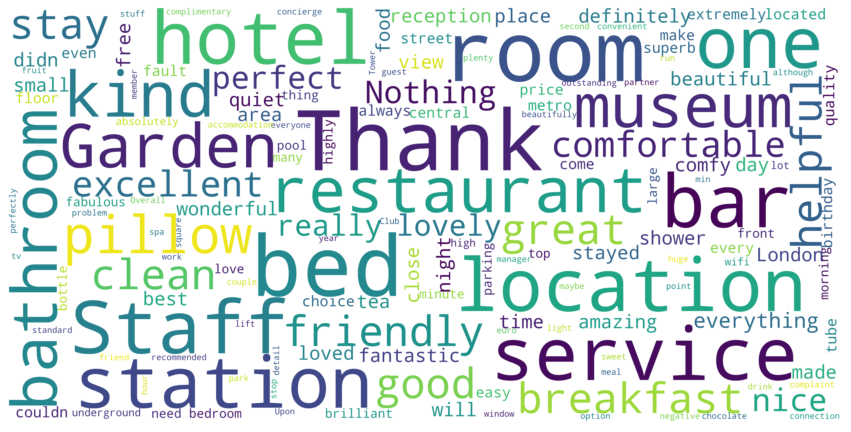

In [38]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in df['reviews'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()